### Andrew Huang Notes ###
Masters in Data Science, Capstone Project, January 21, 2016

andrew.chen.huang@gmail.com

317-402-0832

**Summary and recommendations: **

1. The model I developed ranks the likelihood that a customer will signup based on demographic, vehicle, policy, online attribution, zipcode, and phone data.

2. I recommend incorporating the attribution data into lead scoring (attribution3).

3. I recommend incorporating the zipcode (zipcode_out) data I found from two external sources. The data mostly provides geographic population density and socioeconomic status - features that I found predictive

4. I recommend incorporating the available phone data. The caveat is that most of the phone data (call result, subsequent calls) is not available at the point of predicting ranking the initial call. However you could have an model that re-ranks the accounts to call, including accounts that have been previously calls. In this case, information about the prior call result would be useful.

5. Feature selection based on GBTree feature importance can reduce features by 1/3rd with little/no loss in performance

**Order of the notebook below:**
- Import data, encoding, transformation to create data to model (out5)
- Chart showing online attribution activity with attributions after customer signup excluded
- Gradient Boosted Trees with all data (initial phone data, excludes subsequent calls)
- Gradient Boosted Trees with all data, features selected by feature importance
- Gradient Boosted Trees, exclude the phone data set
- Gradient Boosted Trees, exclude the attribution data set
- Random Forests with all data
- Logistic Regression with all data

In [103]:
from __future__ import division
import pandas as pd
import numpy as np
import pylab as plt
import time
import sklearn
import datetime
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn import preprocessing
%matplotlib inline

In [104]:
#original metromile tables
attribution = pd.read_csv('attribution.csv')
converted = pd.read_csv('converted.csv')
drivers = pd.read_csv('drivers.csv')
phone = pd.read_csv('phone.csv')
policies = pd.read_csv('policies.csv')
vehicles = pd.read_csv('vehicles.csv')

phone_experiment = pd.read_csv('phone_experiment.csv')
phone_experiment = phone_experiment.rename(columns={"AccountNo": "account_number"})
phone_experiment = phone_experiment.drop_duplicates()
phone_experiment = phone_experiment.set_index('account_number')

#additional datasets
#http://federalgovernmentzipcodes.us/
zipcode = pd.read_csv('zipcode-database.csv')
#http://blog.splitwise.com/2014/01/06/free-us-population-density-and-unemployment-rate-by-zip-code/
zipcode_unempl = pd.read_csv('Unemployment+Unsorted.csv')
zipcode_density = pd.read_csv('Zipcode-ZCTA-Population-Density-And-Area-Unsorted.csv')

In [105]:
sources = ['attribution', 'converted','drivers','phone','policies','vehicles','zipcode','zipcode_unempl','zipcode_density']
for source in sources:
    print "name: {}     shape: {}".format(source, eval(source).shape)

name: attribution     shape: (386877, 6)
name: converted     shape: (7791, 2)
name: drivers     shape: (61049, 12)
name: phone     shape: (26848, 3)
name: policies     shape: (42946, 15)
name: vehicles     shape: (51534, 10)
name: zipcode     shape: (81831, 20)
name: zipcode_unempl     shape: (33120, 3)
name: zipcode_density     shape: (33144, 4)


In [106]:
def model_eval(xTr,yTr,xTe, yTe, model):
    from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
    
    model.fit(xTr, yTr)
    
    predict = model.predict(xTe)
    predict_prob = model.predict_proba(xTe)[:,1]
    top_decile_cutoff = int(len(xTe) * 0.9)
    top_decile_esign = np.mean(yTe[np.argsort(predict_prob)][top_decile_cutoff:])
    esign = np.mean(yTe)
    
    print "top decile esign rate: {}".format(round(top_decile_esign, 4))
    print "average esign rate: {}".format(round(esign,4))
    print "top decile esign / avg. esign: {}".format(round(top_decile_esign / esign,4))
    print ""                                      
    print "F1 Score: {}".format(round(f1_score(yTe, predict),4))
    print "accuracy: {}".format(round(accuracy_score(yTe, predict),4))
    print "precision: {}".format(round(precision_score(yTe, predict),4))
    print "recall: {}".format(round(recall_score(yTe, predict),4))
    print "confusion matrix:"
    print  confusion_matrix(yTe, predict)
    
    roc = sklearn.metrics.roc_curve(yTe, predict_prob)
    auc = sklearn.metrics.roc_auc_score(yTe, predict_prob)
    
    plt.figure(figsize=(6, 4))
    plt.plot(roc[0],roc[1])
    plt.plot(np.linspace(0,1,101),np.linspace(0,1,101), '--',c='k')
    plt.title('ROC Curve, AUC: {}'.format(round(auc,3)))
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')

In [122]:
### driver data ###
#filter out secondary drivers. Each account is represented by the data from the primary driver
primary_drivers = drivers[drivers['driver_type']=='Primary']

#filtered by primary drivers, then chose the first field
drivers_out = primary_drivers.groupby('account_number').first()

#merge zipcode sources, before merging with drivers data
zipcode = pd.read_csv('zipcode-database.csv')
zipcode = zipcode.merge(zipcode_unempl, left_on='Zipcode',right_on='Zip',how='left')
zipcode = zipcode.merge(zipcode_density, left_on='Zipcode', right_on='Zip/ZCTA', how='left')
zipcode['Unemp. Rate'] = zipcode['Unemp. Rate'].str[:-1].astype(float)
zipcode_columns = ['Zipcode','State','EstimatedPopulation','TaxReturnsFiled','TotalWages','2010 Population','Land-Sq-Mi','Density Per Sq Mile','Unemp. Rate']
zipcode_out = zipcode[zipcode_columns].drop_duplicates()

#drop columns
drivers_drop = ['driver_id','driver_type']

#set as copy to avoid chain indexing
drivers_out2 = drivers_out.copy().reset_index()

#merge with an external zipcode to state
drivers_out2 = pd.merge(left=drivers_out2, right=zipcode_out, left_on='primary_address_postalcode', right_on='Zipcode', how='left')

#converting to an age
drivers_out2['birthyear'] = drivers_out2['birthdate'].str[:4].astype(float)
drivers_out2['age'] = 2015 - drivers_out2['birthyear']

#zipcodes with the first two digits should be similar geographically
drivers_out2['Zipcode_agg'] = np.round(zipcode['Zipcode'],-3)

#per capita stats
drivers_out2['AvgWages'] = drivers_out2['TotalWages'] / drivers_out2['EstimatedPopulation']
drivers_out2['AvgTaxReturnsFiled'] = drivers_out2['TaxReturnsFiled'] / drivers_out2['EstimatedPopulation']

#label encoder
lbl = preprocessing.LabelEncoder()

drivers_label = ['sex', 'residence_status']
for field in drivers_label:
    drivers_out2[field] = lbl.fit_transform(drivers_out2[field])

#one hot encoding
drivers_dummies = ['marital_status','State']
for field in drivers_dummies:
    temp = pd.get_dummies(drivers_out2[field], prefix=field, dummy_na=True)
    drivers_out2[temp.columns] = temp

drivers_drop = ['birthdate','driver_id','driver_type']
drivers_out3 = drivers_out2.drop(drivers_dummies + drivers_drop,1)
drivers_out3 = drivers_out3.set_index('account_number')

In [108]:
### phone data ###
phone_out = phone.copy()
call_result_dummies = pd.get_dummies(phone_out['call_result'])
phone_out[call_result_dummies.columns] = pd.get_dummies(phone['call_result'])

success_contact = np.array(['Contact','Correct Contact','Transfer'])
phone_out['agg_call_success'] = phone_out['call_result'].isin(success_contact) * 2 - 1

#captures all phone data for each account
phone_out2 = phone_out.groupby('account_number').sum()

#convert datetime into features.
#convert Tempe, AZ (phone center) time into local time
phone_out3 = phone_out.merge(drivers_out2[['account_number','State']],how='left')
time_zone_adjust = {'CA':-1,'PA':2,'WA':-1,'IL':1,'OR':-1,'VA':2, 'NaN':-1}
phone_out3['time_zone_adjust'] = phone_out3['State'].map(time_zone_adjust.get)

phone_out3['call_time'] = pd.to_datetime(phone_out3['call_time'])
phone_out3['call_month'] = phone_out3['call_time'].dt.month
phone_out3['call_day'] = phone_out3['call_time'].dt.day
phone_out3['call_hour'] = phone_out3['call_time'].dt.hour
phone_out3['call_hour_local'] = phone_out3['call_hour'] + phone_out3['time_zone_adjust']
phone_out3['call_minute'] = phone_out3['call_time'].dt.minute

#phone_out3 excludes data after initial call
phone_out3 = phone_out3.sort('call_time').groupby('account_number').first()
phone_drop = ['call_time','call_result', 'State']
phone_out3 = phone_out3.drop(phone_drop,1)

#phone_out4 also excludes the result of the initial call
initial_phone_drop = ['Bad Number', 'Busy', 'Contact', 'Correct Contact',
       'Left Live Message', 'Left Voicemail', 'No Answer', 'Set Callback',
       'Transfer', 'Wrong Number', 'agg_call_success', 'time_zone_adjust']
phone_out4 = phone_out3.drop(initial_phone_drop,1)

In [109]:
policies_out = policies.groupby('account_number').first()

#drop quote status. probably indicates whether someone has already signed up
policies_drop = ['policy_date_entered','quote_status']
policies_out2 = policies_out.drop(policies_drop,1)

#100+ different insurance companies. simply encoding T/F 
policies_out2['prior_insurance_company'] = policies_out2['prior_insurance_company'].notnull()

#encode ordinal features
policies_label = ['has_tnc']
for field in policies_label:
    policies_out2[field] = lbl.fit_transform(policies_out2[field])

#one hot encoding
policies_dummies = ['product_state','product_enum','prior_insurance','prior_bi_limit']

for field in policies_dummies:
    one_hot = pd.get_dummies(policies_out2[field], prefix=field,dummy_na=True)
    policies_out2[one_hot.columns] = one_hot
    
policies_out3 = policies_out2.drop(policies_dummies, 1)

In [110]:
### vehicle data ###
vehicles_out = vehicles.groupby('account_number').first()

#drop current daily base, variable, and prior year mileage. i don't think these are knowable at point of first call
vehicles_drop = ['vehicle_id_c','loan_lending_company','reported_prior_yearly_mileage', 'current_total_daily_base','current_total_per_mile']
vehicles_out2 = vehicles_out.drop(vehicles_drop,1)

#group uncommon makes and models as "other"
top_makes = vehicles_out2['make'].value_counts().index[:20]
vehicles_out2['make'].ix[~vehicles_out2['make'].isin(top_makes)] = "Other"

top_models = vehicles_out2['model'].value_counts().index[:50]
vehicles_out2['model'].ix[~vehicles_out2['model'].isin(top_models)] = "Other"

#encode ordinal features
policies_label = []
for field in policies_label:
    vehicles_out2[field] = lbl.fit_transform(vehicles_out2[field])

#one hot encoding
vehicles_dummies = ['make','model','ownership_type']

for field in vehicles_dummies:
    one_hot = pd.get_dummies(vehicles_out2[field], prefix=field)
    vehicles_out2[one_hot.columns] = one_hot
    
vehicles_out3 = vehicles_out2.drop(vehicles_dummies, 1)

likelihood of signup declines over time, especially after 3 weeks


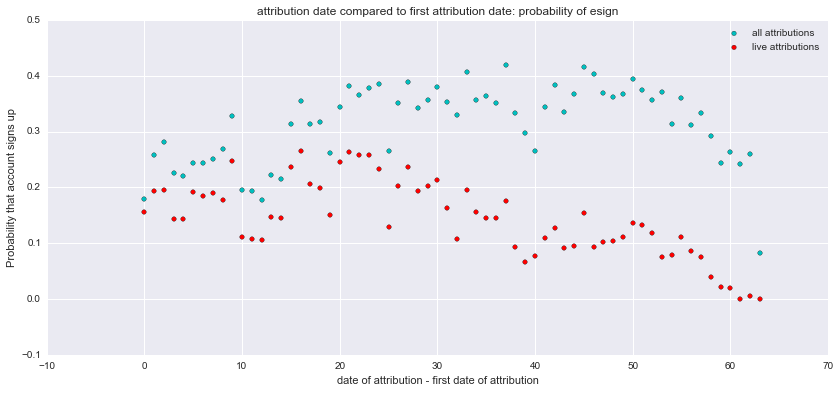

In [111]:
#analysis showing that customers that already signed up show up in attribution activity
#ultimately, I chose to filter out attribution data after the initial phone call
attrib_converted = attribution.merge(converted, how='left')
attrib_converted['esign_bool'] = pd.notnull(attrib_converted['esign_datetime'])

attrib_converted2 = attrib_converted.sort(['account_number','weblog_ts']).reset_index(drop=True)

attrib_converted2['weblog_ts'] = pd.to_datetime(attrib_converted2['weblog_ts'])
attrib_converted2['esign_datetime'] = pd.to_datetime(attrib_converted2['esign_datetime'])

#adding data about first attribution date
first_contact = attrib_converted2.groupby('account_number').first()
first_contact.rename(columns={'weblog_ts':'first_weblog_ts'}, inplace=True)                                                  
first_contact['esign_weblog_daydiff'] = (first_contact['esign_datetime'] - first_contact['first_weblog_ts']).dt.days
first_contact = first_contact.reset_index()

#merging first contact info back to attribution level table
attrib_converted3 = attrib_converted2.merge(first_contact[['account_number','first_weblog_ts']])
attrib_converted3['weblog_delta_days'] = (attrib_converted3['weblog_ts'] - attrib_converted3['first_weblog_ts']).dt.days

#account signed up as of attribution date
attrib_converted3['live_attribution'] = ~(attrib_converted3['weblog_ts'] - attrib_converted3['esign_datetime'] > 0)
attrib_converted3['esign_bool_asof'] = ~attrib_converted3['live_attribution']

#all attributions
delta_days_esign = (attrib_converted3.groupby('weblog_delta_days').sum()['esign_bool'] / attrib_converted3.groupby('weblog_delta_days').count()['esign_bool'])
delta_days_esign = delta_days_esign.reset_index()
#alive attributions
attrib_alive = attrib_converted3[attrib_converted3['live_attribution']]
delta_days_esign_alive = (attrib_alive.groupby('weblog_delta_days').sum()['esign_bool'] / attrib_alive.groupby('weblog_delta_days').count()['esign_bool'])
delta_days_esign_alive = delta_days_esign_alive.reset_index()

print 'likelihood of signup declines over time, especially after 3 weeks'
plt.figure(figsize=(14,6))
plt.scatter(delta_days_esign.ix[:,0],delta_days_esign.ix[:,1],c='c',label='all attributions')
plt.scatter(delta_days_esign_alive.ix[:,0],delta_days_esign_alive.ix[:,1], c='r', label = 'live attributions')

plt.ylabel('Probability that account signs up')
plt.xlabel('date of attribution - first date of attribution')

plt.title('attribution date compared to first attribution date: probability of esign')
plt.legend()

In [112]:
### attribution data ###

#filtering attribution activity occuring after first call
first_phone = phone.copy()
first_phone['call_time'] = pd.to_datetime(first_phone['call_time'])
first_phone = first_phone.sort(['account_number','call_time'])
first_phone = first_phone.groupby('account_number').first()

attribution0 = attribution.set_index('account_number')
attr_phone = attribution0.join(first_phone, how='left')
attr_phone['weblog_ts'] = pd.to_datetime(attr_phone['weblog_ts']) 
attr_phone['mask'] = ~((attr_phone['weblog_ts'] - attr_phone['call_time']) > 0)

print 'original attributions'
print attribution.shape[0]

print 'attributions, filtered if after initial phone call'
initialphone_attr = attr_phone.ix[attr_phone['mask']]
print initialphone_attr.shape[0]
print '{0:.4f} change'.format((initialphone_attr.shape[0]- attribution.shape[0]) / attribution.shape[0])
print ''

print 'original unique accounts'
original_uacct = attribution0.index.nunique()
print original_uacct

print 'unique accounts, filtered after initial phone call'
initialphone_uacct = initialphone_attr.index.nunique()
print initialphone_uacct
print '{0:.4f} change'.format((initialphone_uacct- original_uacct) / original_uacct)

original attributions
386877
attributions, filtered if after initial phone call
313924
-0.1886 change

original unique accounts
54949
unique accounts, filtered after initial phone call
54732
-0.0039 change


In [113]:
#bucket small categories to "other"
top_n = 10
attribution1 = initialphone_attr.copy()
mm_category_indicator = attribution1['mm_category'].value_counts().index[:top_n]
source_indicator = attribution1['source'].value_counts().index[:top_n]
medium_indicator = ['cpc','email']
campaign_indicator = attribution1['campaign'].value_counts().index[:top_n]

#convert categorical to dummy variables
attribution2 = attribution1.copy()
attrib_todummy = ['mm_category','source','medium','campaign']
#column name label abbreviations
attrib_todummy_short = ['mm','src','medm','cmpgn']

for idx, col in enumerate(attrib_todummy):
    attribution2[col][~attribution1[col].isin(eval(col + "_indicator"))] = (col + "_other")
    dummies = pd.get_dummies(attribution2[col])
    dummies_columns = attrib_todummy_short[idx] + '_' + dummies.columns
    attribution2[dummies_columns] = dummies
attribution2 = attribution2.drop(attrib_todummy,1)
    
#creating a column of 1's
attribution2['attribution_count'] = 1

#converting datetime to date
attribution2['weblog_date'] = pd.to_datetime(attribution2['weblog_ts']).dt.date

#including all attributions, regardless of multiple visits per day
attribution3 = attribution2.reset_index().groupby('account_number').sum()

#grouping to 1 attribution per day max
attribution4 = attribution2.reset_index().groupby(['account_number','weblog_date']).first()
attribution4 = attribution4.reset_index().groupby('account_number').sum()
attribution4.columns = [col + '_enc' for col in attribution4.columns]

#grouping from attribution to account level
attribution5 = attribution3.join(attribution4)


/Users/aerie/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [114]:
converted_out = converted.copy()
converted_out = converted_out.set_index('account_number')

In [115]:
#attribution5 adds the encoded features of unique daily visitors
#phone2 includes data from all calls (probably introduces leakage)
#phone3 excludes all data after initial call
#phone4 excludes all data prior to initial call (i.e. excludes the initial call result)

#unique accounts with phone activity
out1 = phone_out3.join(converted_out, how = 'left')
out1['esign_boolean'] = pd.notnull(out1['esign_datetime'])*1
out2 = out1.join(drivers_out3, how='left')
out3 = out2.join(policies_out3 , how='left')
out4 = out3.join(vehicles_out3 , how='left')
out5 = out4.join(attribution3, how='left')

#data preparation
y = out5['esign_boolean']
X = out5.drop(['esign_datetime', 'esign_boolean'],1)

#modify incompatible characters for xgboost
col_modified = []
for col in X.columns:
    col_modified.append(col.replace("<","less than").replace(">","greater than"))
X.columns = col_modified    

#logistic regression can't handle NaN. fill with averages, rounded down
for col in X.columns:
    X[col] = X[col].fillna(round(np.mean(X[col]),0))
    
#remove features with zero variation
nm = Normalizer()
zero_var_columns = X.columns[nm.fit_transform(X).var(0) == 0]
X = X.drop(zero_var_columns, 1)

print out1.shape
print out2.shape
print out3.shape
print out4.shape
print out5.shape

#separate training & cross-validation with test
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y)

X_exclAttr = X.drop(list(attribution3.columns & X.columns),1)
Xtrain_exclAttr, Xtest_exclAttr, ytrain_exclAttr, ytest_exclAttr = train_test_split(X_exclAttr,y)

X_exclPhone = X.drop(list(phone_out3.columns & X.columns),1)
Xtrain_exclPhone, Xtest_exclPhone, ytrain_exclPhone, ytest_exclPhone = train_test_split(X_exclPhone,y)

(10045, 19)
(10045, 52)
(10045, 85)
(10045, 161)
(10045, 199)


top decile esign rate: 0.1627
average esign rate: 0.0629
top decile esign / avg. esign: 2.5867

F1 Score: 0.0447
accuracy: 0.9319
precision: 0.1905
recall: 0.0253
confusion matrix:
[[2337   17]
 [ 154    4]]


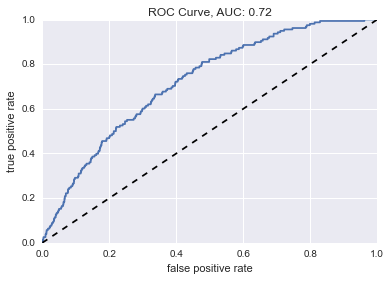

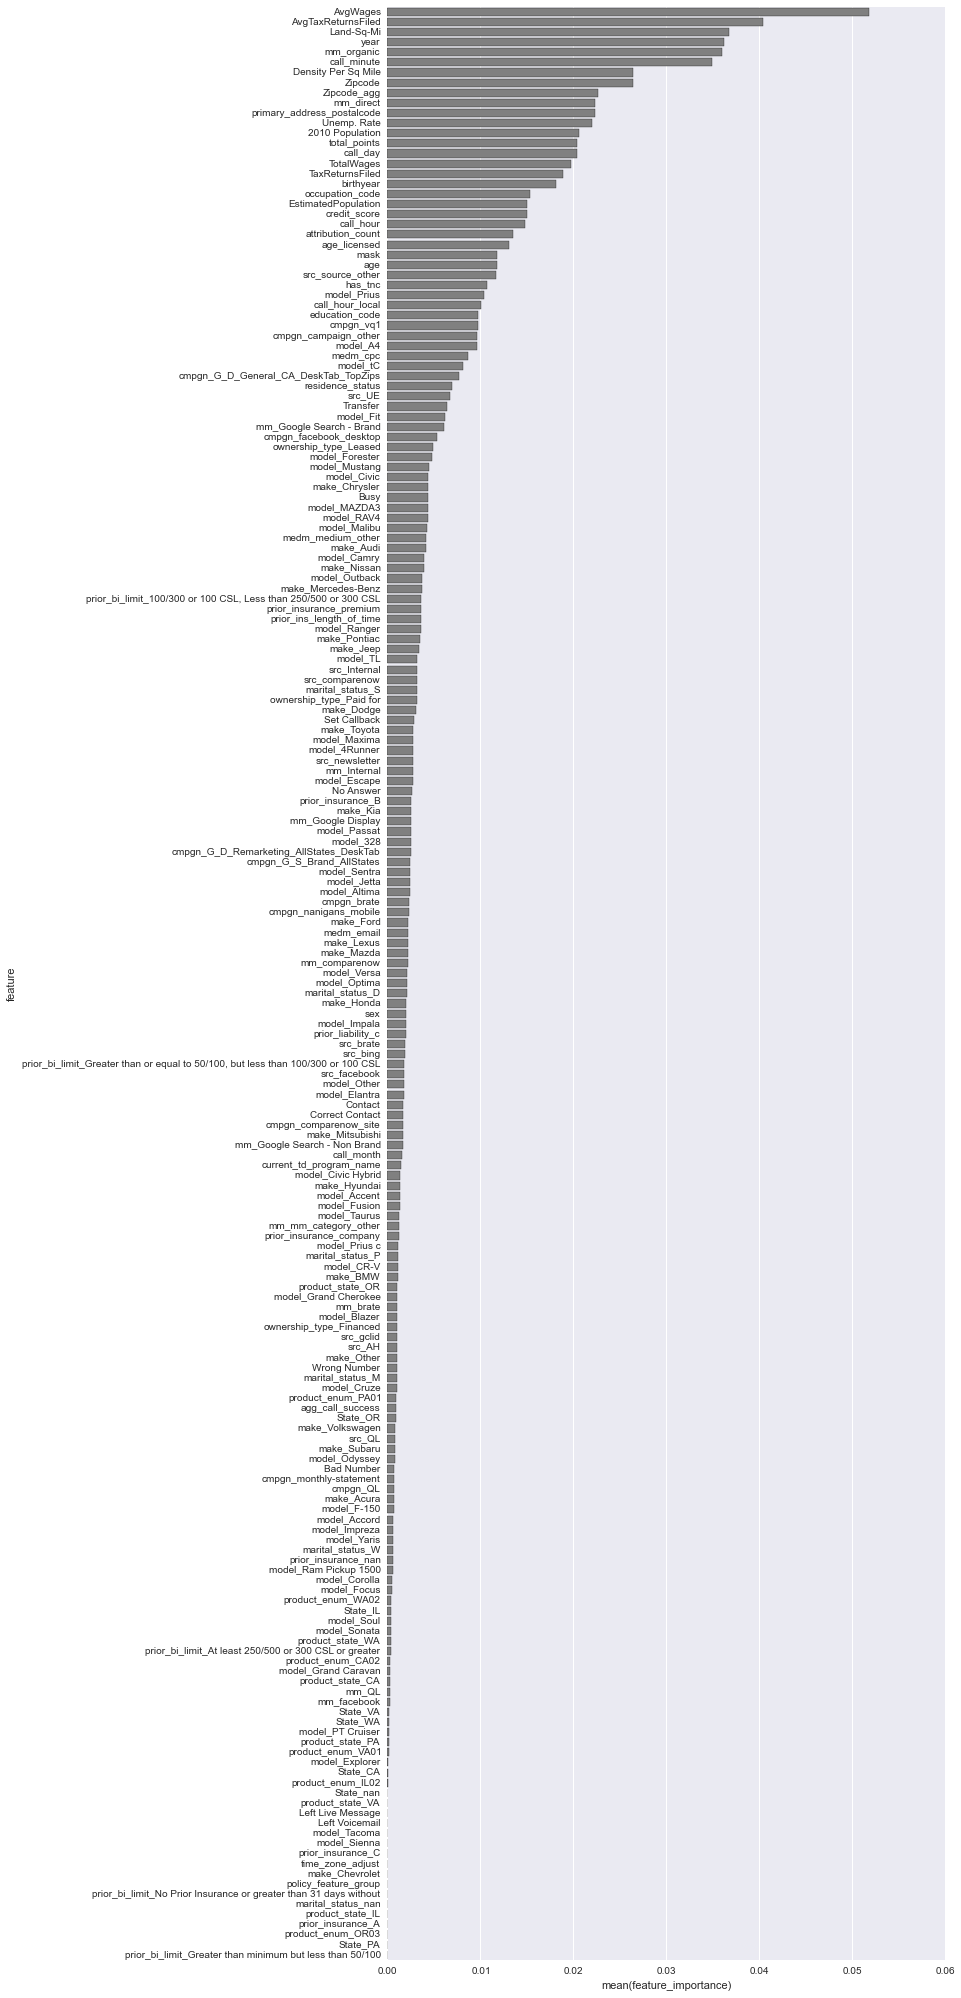

In [116]:
#GBtrees, initial phone call
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(
n_estimators = 230,
learning_rate = 0.07,
max_depth = 5,
subsample = 1,
max_features = None)

model_eval(Xtrain,ytrain, Xtest, ytest,gb)

feature_rank = pd.DataFrame({'feature':Xtrain.columns, 'feature_importance':gb.feature_importances_.round(4)})
feature_rank = feature_rank.sort('feature_importance', ascending=False)

import seaborn as sns
plt.figure(figsize=(10,35))
sns.barplot(y=feature_rank['feature'],x=feature_rank['feature_importance'], color='grey')

top decile esign rate: 0.1548
average esign rate: 0.0629
top decile esign / avg. esign: 2.4605

F1 Score: 0.044
accuracy: 0.9307
precision: 0.1667
recall: 0.0253
confusion matrix:
[[2334   20]
 [ 154    4]]


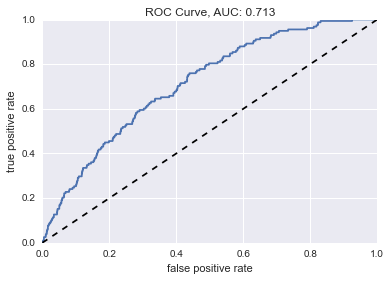

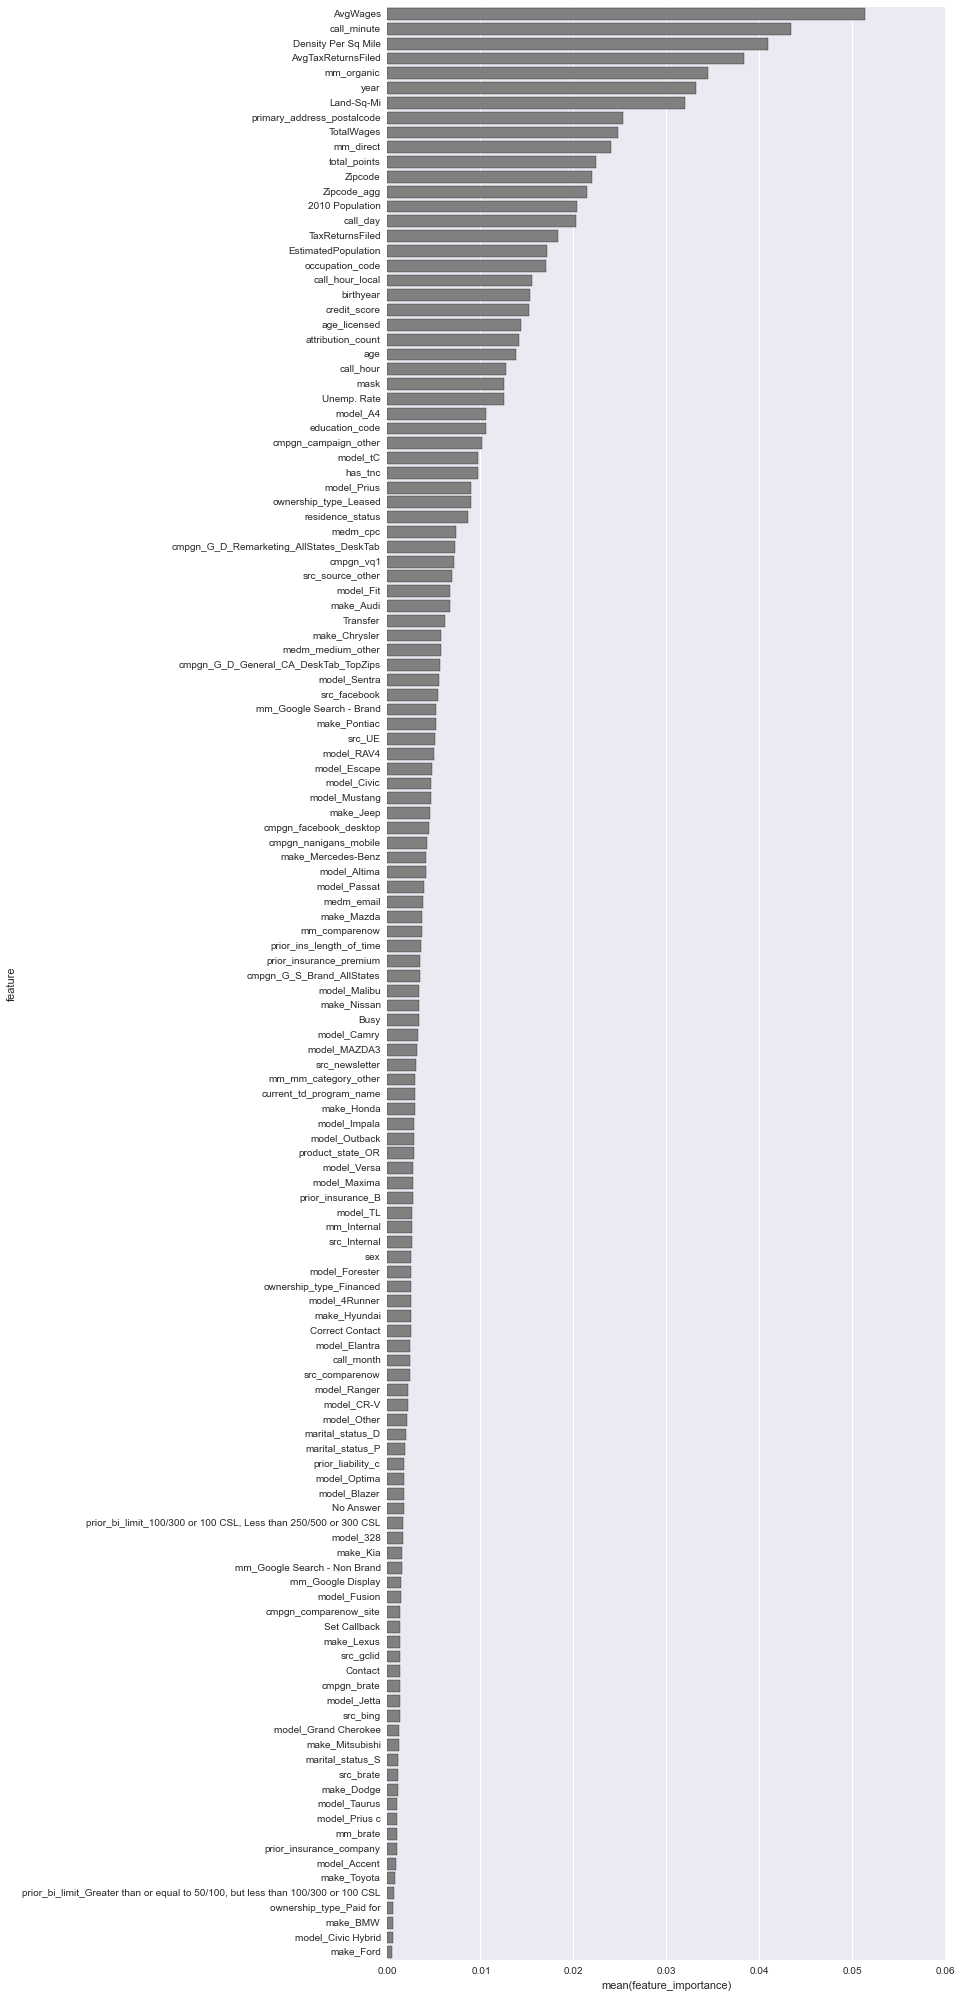

In [117]:
#feature selection based on feature importance threshhold
#GBtrees, Phone unique accounts
feature_threshold = .001
top_features = feature_rank['feature'][feature_rank['feature_importance'] > feature_threshold]

model_eval(Xtrain.ix[:,top_features],ytrain, Xtest.ix[:,top_features], ytest,gb)

feature_rank = pd.DataFrame({'feature':Xtrain.ix[:,top_features].columns, 'feature_importance':gb.feature_importances_.round(4)})
feature_rank = feature_rank.sort('feature_importance', ascending=False)

plt.figure(figsize=(10,35))
sns.barplot(y=feature_rank['feature'],x=feature_rank['feature_importance'], color='grey')

top decile esign rate: 0.1548
average esign rate: 0.0637
top decile esign / avg. esign: 2.4298

F1 Score: 0.0635
accuracy: 0.9295
precision: 0.2069
recall: 0.0375
confusion matrix:
[[2329   23]
 [ 154    6]]


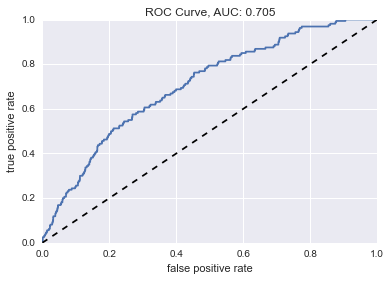

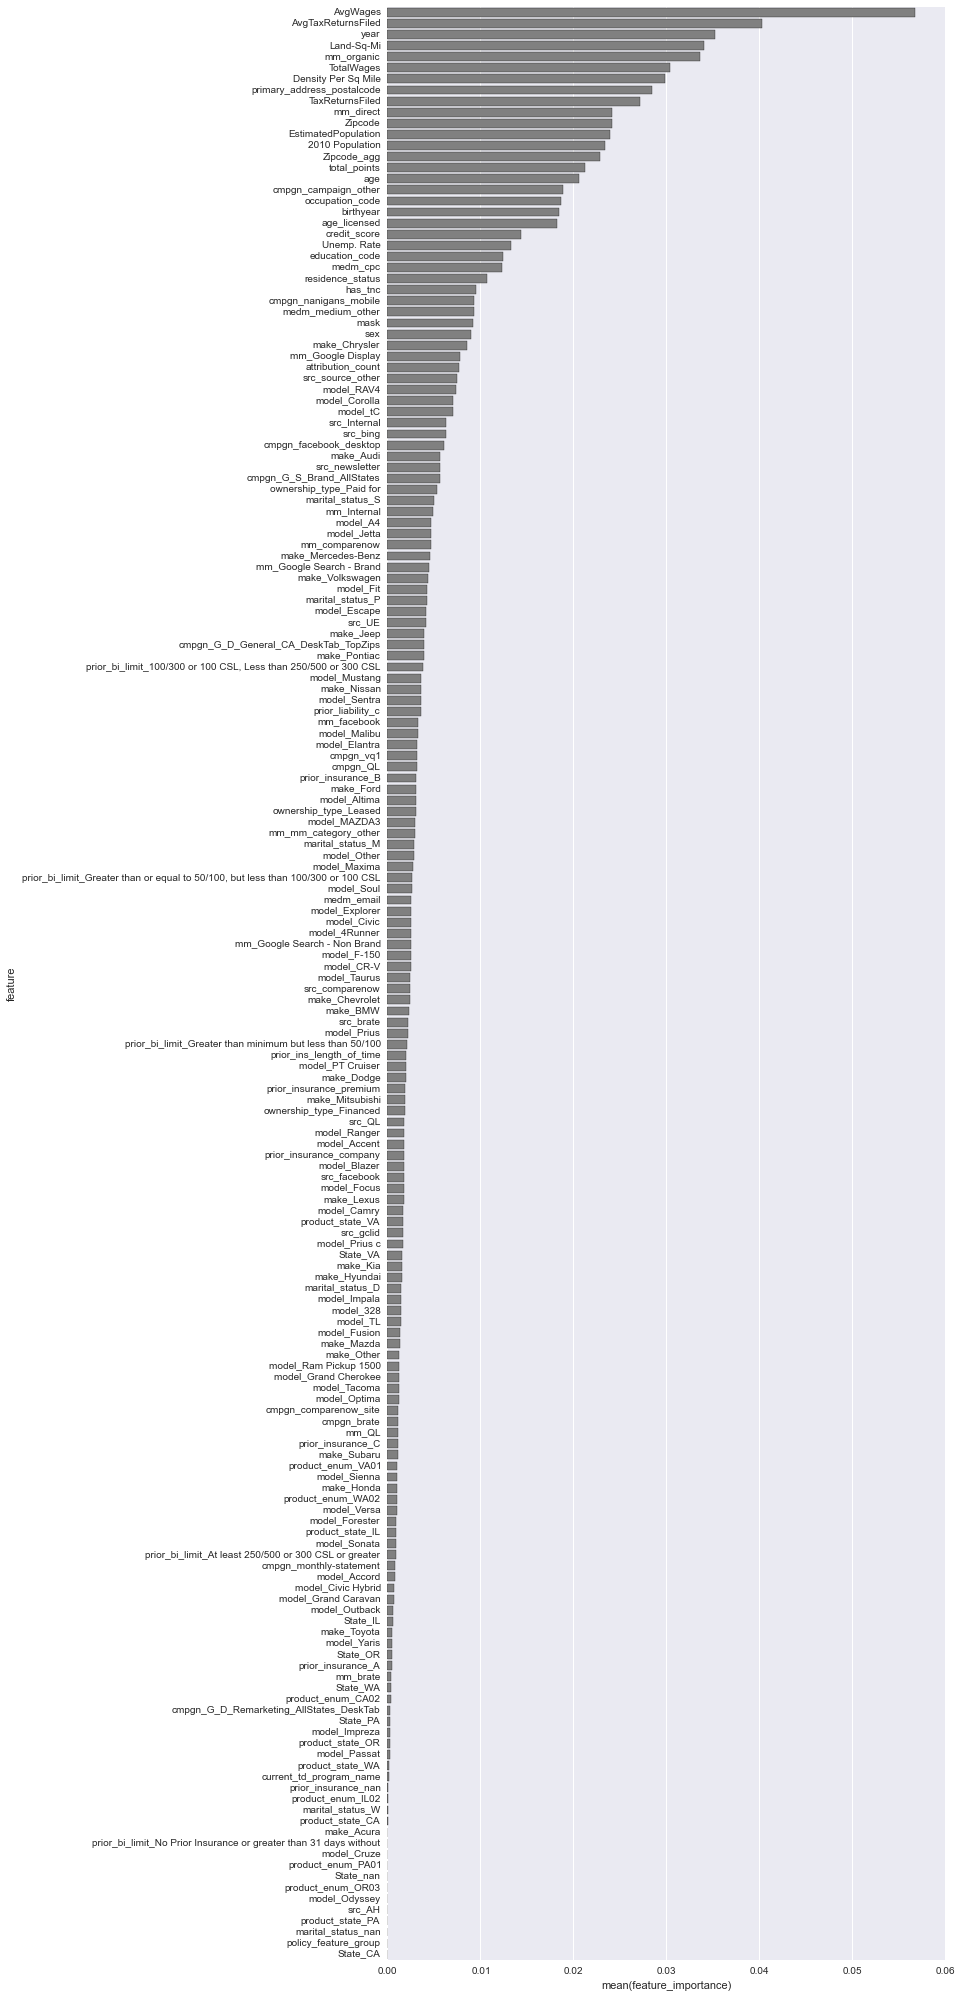

In [118]:
#excludes all phone activity
#GBtrees, initial phone call

model_eval(Xtrain_exclPhone,ytrain_exclPhone, Xtest_exclPhone, ytest_exclPhone,gb)

feature_rank = pd.DataFrame({'feature':Xtrain_exclPhone.columns, 'feature_importance':gb.feature_importances_.round(4)})
feature_rank = feature_rank.sort('feature_importance', ascending=False)

plt.figure(figsize=(10,35))
sns.barplot(y=feature_rank['feature'],x=feature_rank['feature_importance'], color='grey')

top decile esign rate: 0.1032
average esign rate: 0.0641
top decile esign / avg. esign: 1.6098

F1 Score: 0.012
accuracy: 0.9347
precision: 0.2
recall: 0.0062
confusion matrix:
[[2347    4]
 [ 160    1]]


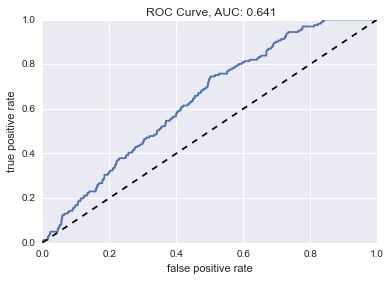

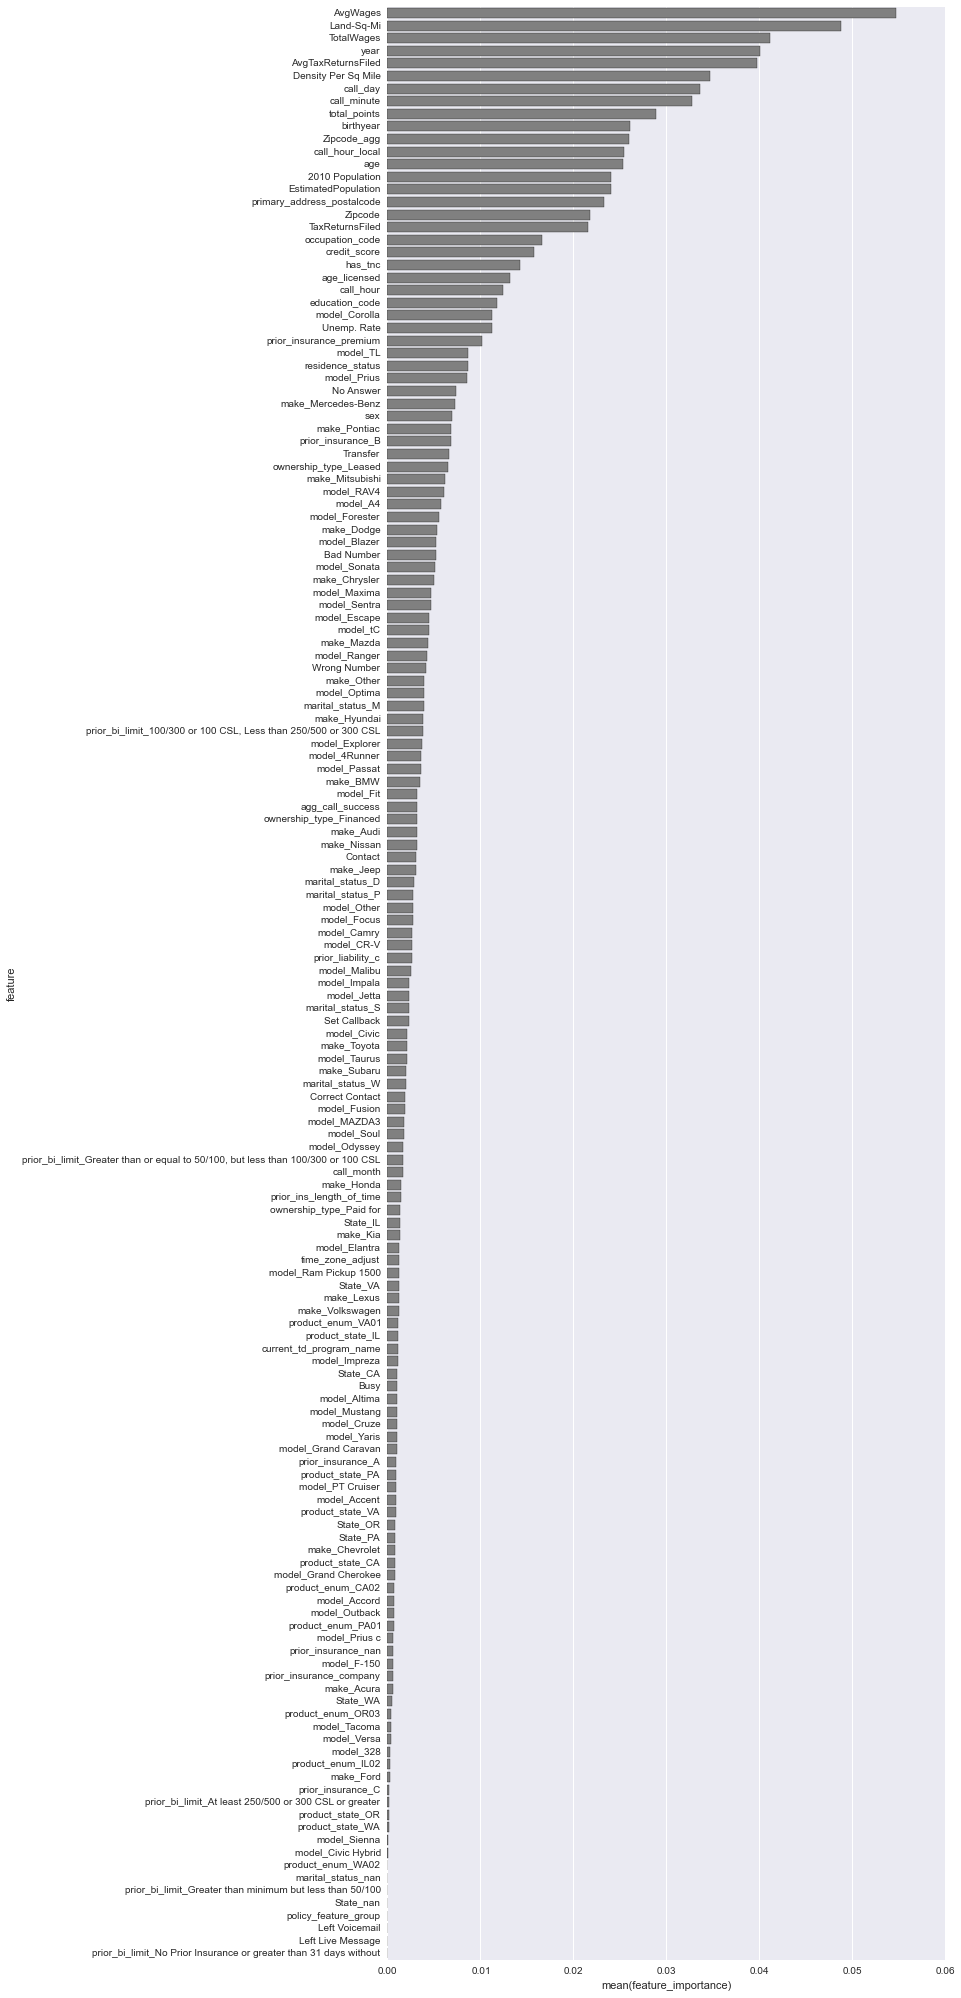

In [119]:
#excludes all attribution activity
#GBtrees, initial phone call

model_eval(Xtrain_exclAttr,ytrain_exclAttr, Xtest_exclAttr, ytest_exclAttr,gb)

feature_rank = pd.DataFrame({'feature':Xtrain_exclAttr.columns, 'feature_importance':gb.feature_importances_.round(4)})
feature_rank = feature_rank.sort('feature_importance', ascending=False)

plt.figure(figsize=(10,35))
sns.barplot(y=feature_rank['feature'],x=feature_rank['feature_importance'], color='grey')

top decile esign rate: 0.1548
average esign rate: 0.0629
top decile esign / avg. esign: 2.4605

F1 Score: 0.0
accuracy: 0.9367
precision: 0.0
recall: 0.0
confusion matrix:
[[2353    1]
 [ 158    0]]


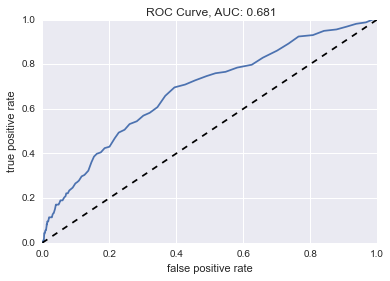

In [120]:
#Random forest, Attribution unique accounts
rf = RandomForestClassifier(n_estimators=300)
model_eval(Xtrain,ytrain, Xtest, ytest, rf )

top decile esign rate: 0.1865
average esign rate: 0.0629
top decile esign / avg. esign: 2.9652

F1 Score: 0.0606
accuracy: 0.9383
precision: 0.7143
recall: 0.0316
confusion matrix:
[[2352    2]
 [ 153    5]]


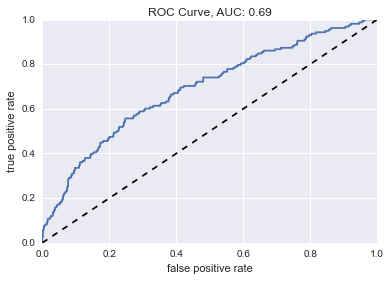

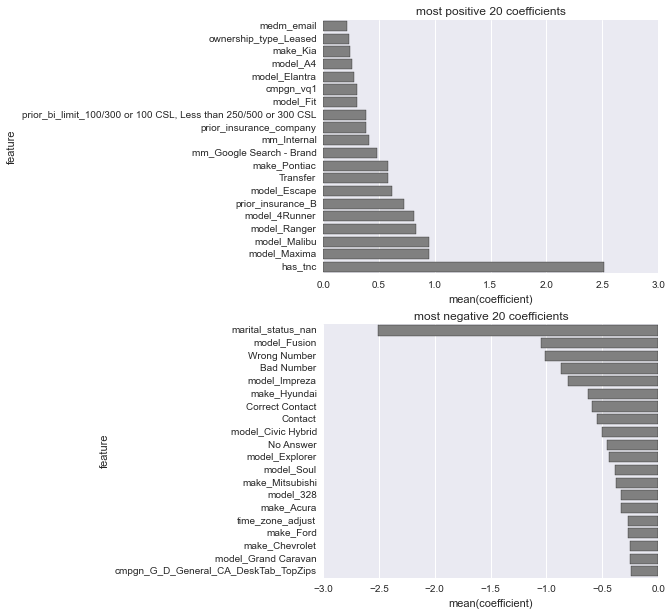

In [121]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1')
model_eval(Xtrain,ytrain, Xtest, ytest, lr)

pd.options.display.float_format = '{:,.3f}'.format
feature_coef = pd.DataFrame({'feature':Xtrain.columns,'coefficient': lr.coef_[0]})
feature_coef = feature_coef.sort('coefficient')

f, (ax1, ax2) = plt.subplots(2,1, figsize=(6,10))
ax1.set_title('most positive {} coefficients'.format(top_coef))
sns.barplot(y=feature_coef['feature'][-top_coef:],x=feature_coef['coefficient'][-top_coef:], color='grey', ax=ax1)
ax2.set_title('most negative {} coefficients'.format(top_coef))
sns.barplot(y=feature_coef['feature'][:top_coef],x=feature_coef['coefficient'][:top_coef], color='grey',ax=ax2)